# Để xây dựng mô hình dự báo biến động giá cổ phiếu, em sẽ sử dụng phương pháp LSTM (mạng neuron dài và ngắn)

In [2]:
import pandas as pd # Đọc và xử lý dữ liệu
import numpy as np # Xử lý dữ liệu
from datetime import datetime as datetime # Chỉnh dữ liệu thời gian
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # Lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense # Đầu ra




# Kiểm định độ chính xác của mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo phần trăm sai số tuyệt đối trung bình


# Đọc, xử lý và biến đổi dữ liệu

In [3]:
df = pd.read_csv('VIC.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,10/17/2018 9:39,98.5,98.5,98.5,98.5,390,0
1,VIC,10/17/2018 9:40,98.5,98.5,98.5,98.5,760,0
2,VIC,10/17/2018 9:41,98.6,98.6,98.6,98.6,2060,0
3,VIC,10/17/2018 9:42,98.6,98.6,98.6,98.6,5540,0
4,VIC,10/17/2018 9:43,98.6,98.7,98.6,98.7,760,0


In [4]:
# Thông tin bộ dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         101266 non-null  object 
 1   Date/Time      101266 non-null  object 
 2   Open           101266 non-null  float64
 3   High           101266 non-null  float64
 4   Low            101266 non-null  float64
 5   Close          101266 non-null  float64
 6   Volume         101266 non-null  int64  
 7   Open Interest  101266 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 6.2+ MB


=> Không có dữ liệu khuyết thiếu

In [5]:
# Mô tả bộ dữ liệu
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05,101266.0
mean,105.376460,105.418519,105.334147,105.378791,3.182640e+03,0.0
std,11.543158,11.535584,11.552338,11.545054,1.469814e+04,0.0
min,68.000000,68.000000,68.000000,68.000000,1.000000e+01,0.0
25%,95.400000,95.400000,95.300000,95.400000,2.300000e+02,0.0
50%,105.300000,105.300000,105.200000,105.300000,1.020000e+03,0.0
75%,115.800000,115.900000,115.800000,115.800000,3.000000e+03,0.0
max,126.100000,126.500000,126.100000,126.500000,1.468390e+06,0.0


In [6]:
df['Date/Time'] = pd.to_datetime(df["Date/Time"]) # chỉnh kiểu dữ liệu của cột Date/Time
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,VIC,2018-10-17 09:39:00,98.5,98.5,98.5,98.5,390,0
1,VIC,2018-10-17 09:40:00,98.5,98.5,98.5,98.5,760,0
2,VIC,2018-10-17 09:41:00,98.6,98.6,98.6,98.6,2060,0
3,VIC,2018-10-17 09:42:00,98.6,98.6,98.6,98.6,5540,0
4,VIC,2018-10-17 09:43:00,98.6,98.7,98.6,98.7,760,0


In [7]:
# Tạo list ngày tháng năm
Date = []
for i in df['Date/Time']:
    if datetime.strftime(i,"%Y-%m-%d") not in Date:
        Date.append(datetime.strftime(i,"%Y-%m-%d"))
print(Date)


['2018-10-17', '2018-10-18', '2018-10-19', '2018-10-22', '2018-10-23', '2018-10-24', '2018-10-25', '2018-10-26', '2018-10-29', '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02', '2018-11-05', '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09', '2018-11-12', '2018-11-13', '2018-11-14', '2018-11-15', '2018-11-16', '2018-11-19', '2018-11-20', '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29', '2018-11-30', '2018-12-03', '2018-12-04', '2018-12-05', '2018-12-06', '2018-12-07', '2018-12-10', '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28', '2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16', '2019-01-17', '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25', '2019

In [8]:
# Tạo list giá mở cửa, đóng cửa, cao nhất, thấp nhất
Open = []
High = []
Low = []
Close = []
for date in Date:
    subset = df[df['Date/Time'].dt.date == datetime.strptime(date, '%Y-%m-%d').date()]
    Open.append(subset.iloc[0]['Open'])
    High.append(subset['High'].max())
    Low.append(subset['Low'].min())
    Close.append(subset.iloc[-1]['Close'])

In [9]:
# Tạo 1 dataframe chứa dữ liệu giao dịch theo từng ngày
price_data_series = {
    'Tiker':df['Ticker'][:len(Date)],
    'Date': Date,
    'Open': Open,
    'High':High,
    'Low':Low,
    'Close':Close
}
VIC = pd.DataFrame(price_data_series)
VIC

,Tiker,Date,Open,High,Low,Close
0,VIC,2018-10-17,98.5,99.6,98.3,99.0
1,VIC,2018-10-18,98.5,99.2,98.0,99.1
2,VIC,2018-10-19,96.5,99.1,96.5,99.1
3,VIC,2018-10-22,98.1,99.6,97.1,99.1
4,VIC,2018-10-23,98.1,99.0,96.5,99.0
...,...,...,...,...,...,...
543,VIC,2020-12-16,106.8,107.1,105.9,107.0
544,VIC,2020-12-17,106.3,106.9,104.7,104.7
545,VIC,2020-12-18,104.7,106.1,104.5,104.7
546,VIC,2020-12-21,105.5,106.4,104.9,106.4


Mô hình của sẽ sử dụng dữ liệu của giá đóng cửa trong quá khứ làm cơ sở để dự báo giá trong tương lai

=> Vì vậy sẽ lấy ra dữ liệu ngày và giá đóng cửa trong Dataframe VIC

In [10]:
df1 = pd.DataFrame(VIC, columns=['Date','Close'])
df1['Date'] = pd.to_datetime(df1['Date'])
df1.index = df1['Date']
df1.drop('Date',axis=1,inplace=True)
df1

,Close
Date,
2018-10-17,99.0
2018-10-18,99.1
2018-10-19,99.1
2018-10-22,99.1
2018-10-23,99.0
...,...
2020-12-16,107.0
2020-12-17,104.7
2020-12-18,104.7


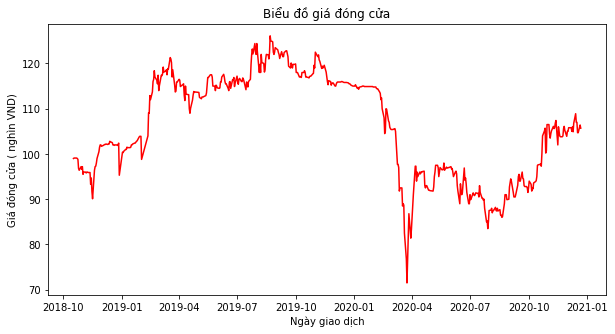

In [11]:
# Vẽ biểu đồ giá đóng cửa 
plt.figure(figsize=(10,5))
plt.plot(df1['Close'],label='Giá thực tế',color='red')
plt.title('Biểu đồ giá đóng cửa')
plt.xlabel('Ngày giao dịch')
plt.ylabel('Giá đóng cửa ( nghìn VND)')
plt.show()

Nhìn vào biểu đồ giá đóng của của mã Chứng khoán VIC từ tháng 10/2018 tới cuối năm 2020 ta thấy: 
+ Vào khoảng thời gian từ cuối năm 2018 tới cuối năm 2019 là đỉnh cao của VIC, đỉnh sau cao hơn đỉnh trước, đáy sau cao hơn đáy trước, và đạt đỉnh vào quý 3 năm 2019 với mức giá 126.1 nghìn VND
+ Tới đầu năm 2020, đại dịch Covid 19 ập đến, với bản chất là 1 cổ phiếu trụ của thị trường, thời gian đầu VIC vẫn rất mạnh mẽ giữ được giá ở trong khoảng hơn 110 nghìn VND, nhưng với tình hình ngày càng tệ VIC cũng không tránh khỏi cú sập do Covid 19 mang lại, nhà đầu tư hoảng loạn đặt bán, khiến cho giá của VIC rơi xuống đáy thấp nhất trong giai đoạn này chỉ còn 71.5 nghìn VND vào tháng 3/2020
+ Nhưng cũng ngay sau đó VIC cũng đã hồi phục cùng với các cổ phiếu trụ khác kéo cả thị trường vực dậy, tới cuối năm 2020, VIC giao dịch xung quanh mức giá 100 nghìn VND

In [14]:
# Chia tập dữ liệu ra thành 2 phần train và test để đánh giá hiệu suất của mô hình học máy trên tập dữ liệu

data = df1.values
train_data = data[:400]
test_data = data[400:]

In [15]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0,1))
# MinmaxScaler sẽ điều chỉnh dữ liệu: giá trị nhỏ nhất sẽ là 0, giá trị lớn nhất sẽ là 1, các giá trị khác sẽ theo tỷ lệ giữa 0 và 1
sc_train = sc.fit_transform(data)

In [32]:
# Ý tưởng của mô hình là sử dụng giá của 40 ngày liên tục để dự đoán giá của ngày tiếp theo
x_train, y_train = [],[]
for i in range(40,len(train_data)):
    x_train.append(sc_train[i-40:i,0])
    y_train.append(sc_train[i,0])

=> x_train sẽ bao gồm các mảng, mỗi bảng sẽ bao gồm 40 giá đóng cửa liên tục
    y_train sẽ bao gồm 1 danh sách giá đóng cửa của ngày hôm sau tương ứng với mỗi mảng của x_train

In [33]:
# Sắp xếp dữ liệu thành 1 mảng
x_train = np.array(x_train)
y_train = np.array(y_train)

# xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

In [34]:
import os
# Bao gồm 5 lớp mô hình
from tensorflow.keras.callbacks import ModelCheckpoint
model = Sequential() # Lớp đầu vào input, tạo lớp mạng cho dữ liệu đầu vào
model.add(LSTM(units=128, input_shape=(x_train.shape[1],1), return_sequences=True)) # Mô tả thông tin của đầu vào 
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Lớp dropout sẽ random đặt 1 số giá trị trong lúc training về bằng 0 để buộc cho máy học phải học lại, tránh tình trạng overfit ( học tủ )
model.add(Dense(units=1)) # Lớp output với đầu ra 1 chiều
model.compile(loss="mean_absolute_error", optimizer='adam') # hàm sai số loss sẽ đo sai số tuyệt đối trung bình
save_model = "C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán/model6.hdf5" # sau khi training sẽ lưu vào file dạng HDF5

best_model = ModelCheckpoint( monitor='loss', verbose=1, save_best_only=True, mode="min",filepath=save_model) # Training tìm ra mô hình huấn luyện tốt nhất và chỉ lưu duy nhất 1 kết quả
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.31584, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 3s - loss: 0.3158 - 3s/epoch - 359ms/step
Epoch 2/100

Epoch 2: loss improved from 0.31584 to 0.14906, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.1491 - 347ms/epoch - 43ms/step
Epoch 3/100

Epoch 3: loss improved from 0.14906 to 0.12803, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.1280 - 344ms/epoch - 43ms/step
Epoch 4/100

Epoch 4: loss improved from 0.12803 to 0.11821, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.1182 - 370ms/epoch - 46ms/step
Epoch 5/100

Epoch 5: loss improved from 0.11821 to 0.11202, saving model to C:/Users/DD/Desktop/Phân tích và dự báo giá chứng khoán\model6.hdf5
8/8 - 0s - loss: 0.1120 - 351ms/epoch - 44ms/step
Epoch 6/100

Epoch 6: loss impr

Trong 100 lần training nếu mô hình nào có sai số tuyệt đối trung bình nhỏ hơn mô hình trước thì sẽ được tự động lưu vào file HDF5 và ghi đè lên mô hình đã lưu trước đó ( Vì save_best_only = True)

In [35]:
# Sau khi tìm được mô hình tốt nhất và lưu trong file 'model6.hdf5', tải lên lại mô hình và áp dụng dự đoán vào tập train
import io
import h5py
with open('model6.hdf5', 'rb') as f:
    file_content = f.read()
    with io.BytesIO(file_content) as file:
        with h5py.File(file, 'r') as hdf:
            final_model = load_model(hdf)

y_train = sc.inverse_transform(y_train) # giá thực
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict) # Giá dự đoán

# Dùng inverse_tranform để điều chỉnh về định dạnh dữ liệu gốc vì dữ liệu đang được chuẩn hóa ở dạng trong khoảng từ 0 đến 1

12/12 [==============================] - 1s 9ms/step


# Sử dụng mô hình

In [36]:
# Với tập test làm tương tự như tập train
test = df1[len(train_data)-40:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(40,test.shape[0]):
    x_test.append(sc_test[i-40:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


# dữ liệu test
y_test = data[400:] # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) # giá dự đoán

5/5 [==============================] - 0s 9ms/step


# Độ chính xác của mô hình

C:\Users\DD\AppData\Local\Temp\ipykernel_9428\1296178694.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['dự đoán'] = y_train_predict
C:\Users\DD\AppData\Local\Temp\ipykernel_9428\1296178694.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict


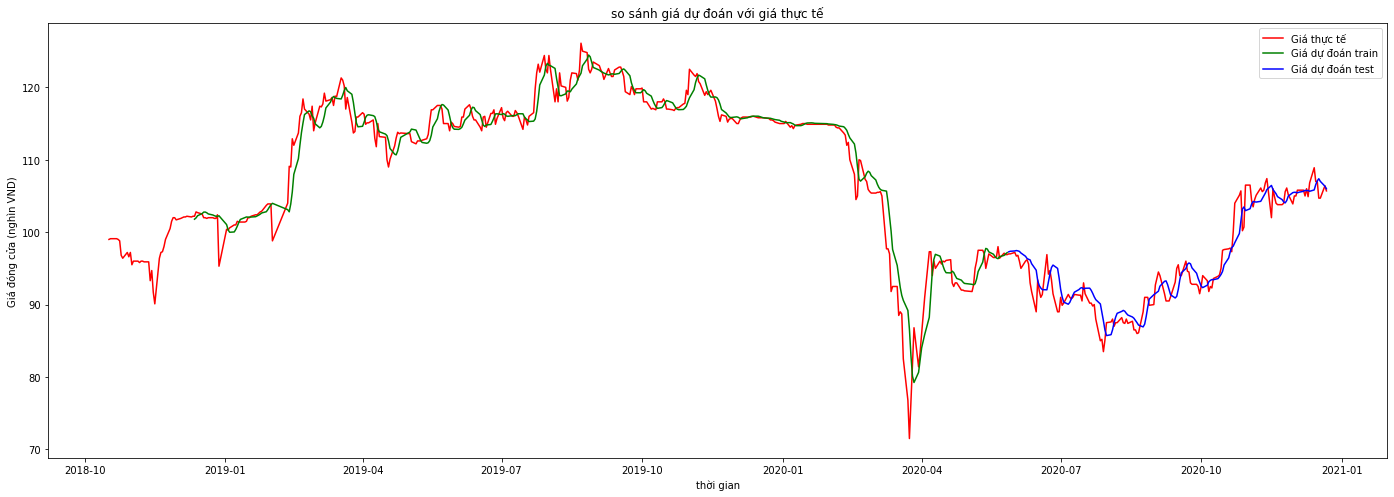

In [37]:
train_data1 = df1[40:400]
test_data1 = df1[400:]

plt.figure(figsize=(24,8))

plt.plot(df1,label='Giá thực tế',color='red')


train_data1['dự đoán'] = y_train_predict

plt.plot(train_data1['dự đoán'], label='Giá dự đoán train', color='green')


test_data1['Dự đoán'] = y_test_predict
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')

plt.title("so sánh giá dự đoán với giá thực tế")

plt.xlabel('thời gian')

plt.ylabel('Giá đóng cửa (nghìn VND)')
plt.legend()

plt.show()

Để kiểm tra độ chính xác của mô hình, đầu tiên ta lập biểu đồ so sánh ở trên cả 2 tập.

+ Với giá thực tế của cổ phiếu được biểu diễn bằng đường màu đỏ
+ Giá dự đoán của tập train được biểu diễn bằng đường màu xanh lá
+ Giá dự đoán của tập test được biển diễn bằng đường màu xanh dương

Để cụ thể hơn thì sẽ đánh giá bằng r2_score

In [38]:
#r2
print('Độ phù hợp của tập train: ',r2_score(y_train, y_train_predict))

#mae
print('Sai số tuyệt đối trung bình tập train: ',mean_absolute_error(y_train,y_train_predict))

#mape
print('Phần trăm sai số tuyệt đối trung bình tập train: ',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp của tập train:  0.9447016704133734
Sai số tuyệt đối trung bình tập train:  1.4581135304768882
Phần trăm sai số tuyệt đối trung bình tập train:  0.013922358327744513


In [39]:
train_data1

,Close,dự đoán
Date,,
2018-12-12,102.2,101.792694
2018-12-13,102.8,101.973633
2018-12-14,102.7,102.271530
2018-12-17,102.5,102.566750
2018-12-18,102.0,102.768784
...,...,...
2020-05-21,98.0,96.337418
2020-05-22,96.4,96.624931
2020-05-25,97.1,96.792519


In [40]:
#r2
print('Độ phù hợp của tập test: ',r2_score(y_test, y_test_predict))

#mae
print('Sai số tuyệt đối trung bình tập test: ',mean_absolute_error(y_test,y_test_predict))

#mape
print('Phần trăm sai số tuyệt đối trung bình tập train: ',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp của tập test:  0.9100380072882781
Sai số tuyệt đối trung bình tập test:  1.5451519940350502
Phần trăm sai số tuyệt đối trung bình tập train:  0.016351328525894823


In [41]:
test_data1

,Close,Dự đoán
Date,,
2020-05-28,97.0,97.284317
2020-05-29,97.0,97.361717
2020-06-01,97.2,97.406113
2020-06-02,96.7,97.461693
2020-06-03,96.8,97.418724
...,...,...
2020-12-16,107.0,107.087166
2020-12-17,104.7,107.380981
2020-12-18,104.7,107.015663


Với mã ck VIC thì mô hình dự đoán LSTM cũng cho ra một độ phù hợp khá cao, trên 94% với tập train và trên 91% với tập test
=> Có thể thấy là mô hình dự đoán biến động giá chứng khoán có sử dụng thuật bán LSTM cho ra 1 kết quả dự đoán khá cao, có thế giúp ích được cho các nhà đầu tư trong việc đưa ra các quyết định trong thị trường chứng khoán.

=> Tuy nhiên trong thị trường này còn rất nhiều yếu tố khác nhau có thể tác động tới xu hướng biến động của giá cổ phiếu cũng như độ sai số của mô hình, vì vậy các nhà đầu tư chỉ nên tham khảo và có những nhận định kĩ lưỡng trước khi đưa ra quyết định đầu tư